Hi Theresia,

in this script, I try to use RL to solve the knapsack problem.
This should not be an exciting project but just a warm up (for me at least) to understand hands-on RL, RNN, embeddings and such.


Still to implement:
- mask to not choose 'wrong' objects
- for now, it works only with batches of size one.

As always, we start by importing useful libraries and defiening some boundary conditions

In [39]:
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd
import torch 
import random
import itertools    

%matplotlib inline

random.seed(1234)

Then we define the object class

In [40]:
class ObjectCass:
    
    Prize = None
    Weight = None
    
    def __init__(self, reward, weight):
        
        self.Prize = reward
        self.Weight = weight

Now we define the function to generate new instances.
This is a 'fake' instance generator because it generates always the same instance. This is done just to be able to see more easily if the algorithm is learning.
Also, since RL are though to minimize something, the prices of the objects are negative.

The instance generates num_objs objects. 
THe even ones have prize -1 and weight (2/num_objs)- epsilon (epsilon being a small numer), while the odd ones have price -0.1 and weight 0.51. The capacity is normalized so the best solution is to choose all and only the even objects (i.e. capacity = num_objects/2 * (2/num_objs)- epsilon < 1 and reward = -1 * num_objects/2 ). 

Finally, note that we add a fake object of weight and prize zero. This works as a 'final token'. When the algorithm sees this, it stops adding objects. The idea is that a good algorithm will add objects until the capacity is almost fully reached and then select this fake object to break the adding objects cycle.

In [41]:
def GenerateANewInstance(num_objs):
    
    # fake code to control the instance I fed it.
    # best solution = [1,0,1,0,1,0,1,0,1,0,1]
    
    Objects = []
    for i in range(num_objs):
        if i%2==1:
            prize = -0.1
            weight = 0.51
            obj = ObjectCass(prize,weight)
            Objects.append(obj)
        else:
            prize = -1
            weight = (2/num_objs)-0.001
            obj = ObjectCass(prize,weight)
            Objects.append(obj)
    Objects.append(ObjectCass(0,0)) # fake object representing that you don't pick up anything
    
    return Objects
    
    # real code    
    
#    Objects = []
#    for i in range(num_objs):
#        prize = round(random.uniform(prize_min, prize_max), 0)
#        weight = round(random.uniform(0.01, 1), 2)
#        obj = ObjectCass(prize,weight)
#        Objects.append(obj)
#    Objects.append(ObjectCass(0,0)) # fake object representing that you don't pick up anything
#                                   # i.e. you stop picking up stuff
#    
#    return Objects

Very simple Actor Net. 
This is just a fully connected nueral network of depth 10.
input dimension [num_objects]*num_obj_features + residual_capacity output dimensions [num_objects]

note that we also pass to the algorithm the residual capacity so that it 'understands' when it should stop adding objects.

In [79]:
class ActorNet_10LayersFullyConnected(torch.nn.Module):
    
    def __init__(self, num_input_features, num_outputs):    
        
        super(ActorNet_10LayersFullyConnected, self).__init__()

        dim_in = (num_input_features+1)*num_outputs
        self.fc_0 = torch.nn.Linear(dim_in,  dim_in)
        self.fc_1 = torch.nn.Linear(dim_in,  dim_in)
        self.fc_2 = torch.nn.Linear(dim_in,  dim_in)
        self.fc_3 = torch.nn.Linear(dim_in,  dim_in)
        self.fc_4 = torch.nn.Linear(dim_in,  dim_in)
        self.fc_5 = torch.nn.Linear(dim_in,  dim_in)
        self.fc_6 = torch.nn.Linear(dim_in,  dim_in)
        self.fc_7 = torch.nn.Linear(dim_in,  dim_in)
        self.fc_8 = torch.nn.Linear(dim_in,  dim_in)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc_last = torch.nn.Linear(dim_in,  num_outputs)
                
        # Xavier initialization
        torch.nn.init.xavier_uniform_(self.fc_0.weight)
        torch.nn.init.xavier_uniform_(self.fc_1.weight)
        torch.nn.init.xavier_uniform_(self.fc_2.weight)
        torch.nn.init.xavier_uniform_(self.fc_3.weight)
        torch.nn.init.xavier_uniform_(self.fc_4.weight)
        torch.nn.init.xavier_uniform_(self.fc_5.weight)
        torch.nn.init.xavier_uniform_(self.fc_6.weight)
        torch.nn.init.xavier_uniform_(self.fc_7.weight)
        torch.nn.init.xavier_uniform_(self.fc_8.weight)
        torch.nn.init.xavier_uniform_(self.fc_last.weight)

    def forward(self, Input_features, residual_capacity):

        # set the capacity as a tensor
        residual_capacity = torch.tensor([residual_capacity]).float()
        residual_capacity.requires_grad = False
        # define relu operation
        ReLU = torch.nn.ReLU()
        # here we transfor the input from a 2x11 tensor to a 1x33 tensor
        # which is 1x22 of input features and the residual capacity is repeted 11 times.
        # so much info about the capacity might be redudndant but also adding it just once
        # in the end is not working so I'm trying something new
        Input_features_list = []
        for el in Input_features:
            # here we concatenate the residual capacity
            aux = torch.cat([el, residual_capacity], dim = 0)
            Input_features_list.append(aux)
        x = torch.cat(Input_features_list, dim = 0)

        # now our vector x is ready to be fed into the NN        
        x = self.fc_0(x)
        x = ReLU(x)
        x = self.fc_1(x)
        x = ReLU(x)
        x = self.fc_2(x)
        x = ReLU(x)
        x = self.fc_3(x)
        x = ReLU(x)
        x = self.fc_4(x)
        x = ReLU(x)
        # dropout
        x = self.dropout(x)
        # end dropout
        x = self.fc_5(x)
        x = ReLU(x)
        x = self.fc_6(x)
        x = ReLU(x)
        x = self.fc_7(x)
        x = ReLU(x)
        x = self.fc_8(x)
        x = ReLU(x)
        x = self.fc_last(x)         
        # computing softmax to obtain probabilities
        x = torch.nn.functional.softmax(x, dim = 0)

        return x

Now we just test if the NN works by feeding it a tensor.

In [80]:
num_input_features = 2 # number of features of an Object
tensors = torch.tensor([[1.1, -1.0],[2.0, 15.0],[1.0, -1.0],[20.0, 12.0],[1.0, -1.0],[2.0, 15.0],[1.0, -1.0],[20.0, 12.0],[1.0, -1.0],[2.0, 15.0],[1.0, -1.0]]).float()

Net_Actor = ActorNet_10LayersFullyConnected(num_input_features, len(tensors))
print('number of parameters: ', sum(p.numel() for p in Net_Actor.parameters() if p.requires_grad))
output = Net_Actor(tensors,0)
print('\n\noutput')
print(output)

number of parameters:  10472


output
tensor([0.1246, 0.1451, 0.1137, 0.0709, 0.0435, 0.0701, 0.0906, 0.0529, 0.1263,
        0.0537, 0.1086], grad_fn=<SoftmaxBackward>)


In theory here we should define the critic network. Since we are just testing if everything works we don't need a critic network. In fact, since we are using a 'fake' instance, we already know that the best reward for one choice is -1 and for a whole sequence is -num_objects/2.

So we move directly to the RL framework.

In this first step, we test if the algorithm can learn in a one-move scenario. i.e. it has to choose only one object.
Hence, we create our fake instance and test if the algorithm can learn to choose one of the fruitful objects.

Last 5 outputs  [tensor([9.8219e-01, 1.4899e-06, 1.7675e-02, 2.0991e-07, 1.3533e-04],
       grad_fn=<SoftmaxBackward>), tensor([9.7785e-01, 2.8807e-06, 2.1918e-02, 3.7410e-07, 2.2431e-04],
       grad_fn=<SoftmaxBackward>), tensor([9.7980e-01, 8.1373e-07, 2.0064e-02, 2.0397e-07, 1.3419e-04],
       grad_fn=<SoftmaxBackward>), tensor([9.7326e-01, 5.0865e-07, 2.6570e-02, 1.6292e-07, 1.7346e-04],
       grad_fn=<SoftmaxBackward>)]
with the fake instance you're testing, 
Best reward = -1 


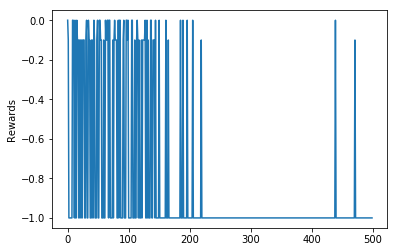

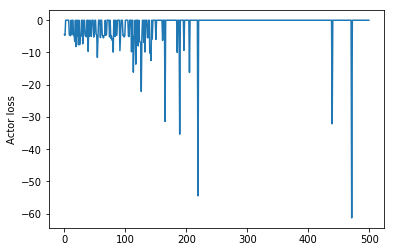

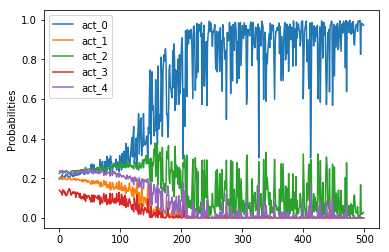

In [81]:
num_objs = 4
Net_Actor = ActorNet_10LayersFullyConnected(num_input_features, num_objs+1)
# define for how many different instances it should run, their size and the number of epochs
num_epoch = 500
# create your optimizers
optimizer_actor = torch.optim.Adam(Net_Actor.parameters(), lr=0.001)
Rewards = []
Loss_actor = []
Loss_critic = []
# fake instance
Objects = GenerateANewInstance(num_objs)
ObjectsFeatures = torch.tensor([[obj.Prize, obj.Weight] for obj in Objects])
ObjectsFeatures.requires_grad = False
Outputs = []
# set to trin the actor
Net_Actor.train()

for e_counter in range(num_epoch):
    optimizer_actor.zero_grad()   # zero the gradient buffers
    total_reward = 0.0
    total_weight = 0.0
    sequence_probability = 1
    Chosen = []
    while True:
        #print('weight', total_weight)
        output = Net_Actor(ObjectsFeatures, total_weight)
        Outputs.append(output)
        action_index = np.random.choice(range(num_objs+1),p=output.detach().numpy())
        action_probability = output[action_index]
        sequence_probability = sequence_probability*action_probability
        #print('sequence probability', sequence_probability)
        # perform action
        total_weight+=Objects[action_index].Weight
        total_reward+=Objects[action_index].Prize
        Chosen.append(Objects[action_index])
        break
    target_actor = torch.tensor([-1])
    target_actor.requires_grad = False
    loss_actor = (torch.tensor(total_reward) - target_actor)*torch.digamma(sequence_probability)
    loss_actor = loss_actor.mean()
    # compute gradient 
    loss_actor.backward()
    # gradient clipping
    clip_value = 1
    for p in Net_Actor.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    # apply gradient
    optimizer_actor.step()
    # info for plotting
    Rewards.append(total_reward)     
    Loss_actor.append(loss_actor.tolist())
    
print('Last 5 outputs ',Outputs[-5:-1])
R = []
A = []
for i in range(len(Rewards)):
    R.append(Rewards[i])
    A.append(Loss_actor[i])
print('with the fake instance you\'re testing, ')
print('Best reward = -1 ')
plt.figure()
plt.plot(R)
plt.ylabel('Rewards')
plt.figure()
plt.plot(A)
plt.ylabel('Actor loss')
plt.figure()
for i in range(len(Outputs[0])):
    ObjectOutput = [o[i] for o in Outputs]
    plt.plot(ObjectOutput, label='act_'+str(i))
plt.ylabel('Probabilities')
plt.legend()

As we can see, it learns to choose any of the fruitful actions (depending on the randomness) within 50 iterations (more or less). The next step is to see if it understands how to select a sequence instead of a single action. 

In [ ]:
# fake instance
num_objs = 4
Objects = GenerateANewInstance(num_objs)
ObjectsFeatures = torch.tensor([[obj.Prize, obj.Weight] for obj in Objects])
ObjectsFeatures.requires_grad = False
# actor network
Net_Actor = ActorNet_10LayersFullyConnected(num_input_features, num_objs+1)
# define the number of epochs
num_epoch = 10000
# create your optimizers
optimizer_actor = torch.optim.Adam(Net_Actor.parameters(), lr=0.01)
# arrays to plot afterwards
Rewards = []
Loss_actor = []
Loss_critic = []
Probabilities = []
# set to trin the actor
Net_Actor.train()

for e_counter in range(num_epoch):
    optimizer_actor.zero_grad()   # zero the gradient buffers
    total_reward = 0.0
    total_weight = 0.0
    sequence_probability = torch.tensor([1]).float()
    Chosen = []
    while True:
        #print('weight', total_weight)
        probabilities = Net_Actor(ObjectsFeatures, total_weight)
        Probabilities.append(probabilities)
        action_index = np.random.choice(range(num_objs+1),p=probabilities.detach().numpy())
        action_probability = probabilities[action_index]
        sequence_probability = sequence_probability*action_probability
        #print('sequence probability', sequence_probability)
        # perform action
        total_weight+=Objects[action_index].Weight
        total_reward+=Objects[action_index].Prize
        Chosen.append(action_index)
        if total_weight > 1:
            total_reward = 0 
            break
        if Objects[action_index].Prize == 0 and Objects[action_index].Weight == 0: # the last fake object = stop
            break
    target_actor = torch.tensor([-num_objs/2]).float()
    target_actor.requires_grad = False
    loss_actor = (torch.tensor(total_reward) - target_actor)*torch.digamma(sequence_probability)
    loss_actor = loss_actor.mean()
    # compute gradient 
    loss_actor.backward()
    # gradient clipping
    clip_value = 1
    for p in Net_Actor.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    # apply gradient
    optimizer_actor.step()
    # info for plotting
    Rewards.append(total_reward)     
    Loss_actor.append(loss_actor.tolist())
    
print('Last 5 probabilities distribution ',Probabilities[-5:-1])
print('last sequence of object chosen: ', Chosen)
R = []
A = []
for i in range(len(Rewards)):
    R.append(Rewards[i])
    A.append(Loss_actor[i])
print('with the fake instance you\'re testing, ')
print('Best reward =, ', -num_objs/2)
plt.figure()
plt.plot(R)
plt.ylabel('Rewards')
plt.figure()
plt.plot(A)
plt.ylabel('Actor loss')
plt.figure()
for i in range(len(Probabilities[0])):
    ObjectOutput = [o[i] for o in Probabilities]
    plt.plot(ObjectOutput, label='act_'+str(i))
plt.ylabel('Probabilities')
plt.legend()

As you can see from the graphs, here the algorithm does not really learn anything. And it does not even seem as it is going towards some stable solution! you can increase the number of epochs (num_epoch) but the result is more or less the same.

A weird thing that can happen (depending on the randomness) is that it selects an action and put its probability to 100%. doing so the log derivative becames quite flat and it stays in this local minima. (Now this does not happen anymore due to the dropout layer)

I can't really understand why it doesn't work. 10 layers should be enough to understand to pick something with weight less then remaining_capacity. The RL structure should be ok, since it worked on the previous case.
So, I don't get why it is not working.

The only thing that can cause problems (I think) it's how we compute the sequence_probability. In the RL formula, sequence_probability = P(Y_n|X_0) which is the probability of sequence Y_n given initial state X_0. I compute this as the product of the probabilities of chosing action a_t at time t. Hence:

sequence_probability = P(Y_n|X_0) = p(action_0|X_0)\*p(action_1|X_1)\*..p(action_n|X_n).

This seems reasonable to me, but it does not work. (I think this might be the problem because it's the only thing we changed with respect to the previous case.)

Do you have any other ideas on why it does not work, Theresia? If so, I would really like to hear them!
P.S. sorry if my code is messy :)

Hi Theresia, from here on are just more complicated actor sructures. Please do not look at them because they are wrong

here is the code of the Actor with RNN and attention

In [ ]:
print('please don\'t run this because it is wrong')
error_to_stop_execution

class ActorNet_with_Attention(torch.nn.Module):
    
    def __init__(self, num_input_features, dim_kernel, num_embeddings, num_h, dim_W_a, dim_W_c, len_sequences):
        
        super(ActorNet, self).__init__() # this is not really clear to me
                                            # input channels 11, output channels 11, 
        self.cnn_embedding = torch.nn.Conv1d(len_sequences, len_sequences, dim_kernel, padding = int((num_embeddings-num_input_features)/2),padding_mode = 'replicate') # in channel, out channel, kernel size
        #self.cnn_embedding = torch.nn.Conv1d(len_sequences, len_sequences, dim_kernel, padding = 2, padding_mode = 'reflect') # in channel, out channel, kernel size
        #self.cnn_embedding = torch.nn.Conv1d(len_sequences, len_sequences, dim_kernel, padding = (num_embeddings-num_input_features)/2, padding_mode = 'reflect') # in channel, out channel, kernel size
        print('still to decide the kernel size')
        print('and how do you set the number of filters to D?')
        print('so far I set the number of groups to num_input_features')
        print('doing so, each input featur has its own set of filters (see documentation)')
        self.lstm= torch.nn.LSTM(num_embeddings,  num_h)        
        self.last_item_embedding = torch.nn.Linear(num_input_features+1,  num_embeddings)
        # the plus one up here is the remaining capacity
        print('also, so far you feed to the LSTM both the static and dinamic info.')
        print('and to match the dimension, you pass this info into a fully connected layer')
        print('you will have to change it, so to feed only the static part')
        self.W_a = torch.tensor(torch.rand(dim_W_a,num_embeddings + num_h), requires_grad=True)
        self.v_a = torch.tensor(torch.rand(dim_W_a), requires_grad=True)
        self.v_a = self.v_a[None, :] # I don't know why you have to add a dimension here
        self.W_c = torch.tensor(torch.rand(dim_W_c, len_sequences + num_embeddings), requires_grad=True)
        self.v_c = torch.tensor(torch.rand(dim_W_c), requires_grad=True)
        self.v_c = self.v_c[None, :] # I don't know why you have to add a dimension here
        # last item defines the last item you selected. 
        # it is initialized as an empty item.
        
        # here I set the first internal state of the RNN.
        # I set it here and not in forwards otherwise it start with different h_0
        # For now it's zero-initialied, but maybe there is something smarter 
        # that can be done.
        
        self.num_layers = 1
        self.num_directions = 1
        self.num_h = num_h
        self.h_0 = torch.zeros( self.num_layers * self.num_directions, 1, self.num_h ) 
        self.c_0 = torch.zeros( self.num_layers * self.num_directions, 1, self.num_h )
        
        print('Xavier Initialization still to do')
        #print('first')
        #print(list(self.W_a))
        #torch.nn.init.xavier_uniform(self.W_a)
        #print('after')
        #print(list(self.W_a))
        #stop
        
    def forward(self, x, last_item):

        ReLU = torch.nn.ReLU()
        # compuitng h_t
        last_item = self.last_item_embedding(last_item)
        last_item = ReLU(last_item)
        last_item = last_item[None, None, :] # add fake batch dimension and fake Length dimension
        # here it is not clear to me why the batch size has to be one?
        # Maybe because here you pass one info at a time??
        h_t, cell_t = self.lstm( last_item, (self.h_0,self.c_0) )  # if you do not provide the initial cell and state, they are by default zero.
        h_t = torch.squeeze(h_t, dim = 0)    # removing the dimension seq_len since it is 1
        h_t = torch.squeeze(h_t, dim = 0)    # removing the dimension batch   since it is 1
        # computing x_bar
        x = x[None,:, :] # I don't know why you have to add a dimension here
        x_bar = self.cnn_embedding(x)
        x_bar = torch.squeeze(x_bar, dim = 0)    # removing the batch dimension since I'm working withou batches
        # concatenation of two tensors
        Concatenations = []
        for x_bar_i in x_bar:
            Concatenations.append(torch.cat((x_bar_i, h_t), 0))
        concatenation_1 = torch.stack(Concatenations, dim = 0)
        concatenation_1 = concatenation_1.t()
        # computing u_t
        u_t = torch.mm(self.v_a,torch.tanh(torch.mm(self.W_a, concatenation_1))).t()  
        # computing a_t
        a_t = torch.nn.functional.softmax(u_t, dim = 0)        
        # computing the context vector c_t
        C_t_array = []
        index = 0
        for row in x_bar:
            C_t_array.append(torch.mul(row, a_t[index]))
            index+=1  
        c_t = torch.stack(C_t_array,dim=0)
        c_t = torch.sum(c_t, dim=1)        
        # concatenation of two tensors
        Concatenations_2 = []
        for x_bar_i in x_bar:
            Concatenations_2.append(torch.cat((x_bar_i, c_t), 0))
        concatenation_2 = torch.stack(Concatenations_2, dim = 0)
        concatenation_2 = concatenation_2.t()        
        # computing u_t_tilde
        u_t_tilde = torch.mm(self.v_c,torch.tanh(torch.mm(self.W_c, concatenation_2)))
        u_t_tilde = torch.squeeze(u_t_tilde, dim = 0)
        # computing actual output
        x = torch.nn.functional.softmax(u_t_tilde)
        
        return x, x_bar

In [ ]:
#create an instance
num_objects = 10
Objects = GenerateANewInstance(num_objects)
for obj in Objects:
    if obj.Prize == 0 and obj.Weight == 0:
        last_item = obj

num_input_features = 2 # number of features of an Object
num_embeddings = 32   # number of features for the embedding
num_h = 32             # number of features for the hidden size of the rnn
dim_W_a = 32           # free dimension of matrix W_a
dim_W_c = 32           # free dimension of matrix W_c
dim_kernel = 1         # kernel dimension
tensors = torch.tensor([[1.1, -1.0],[2.0, 15.0],[1.0, -1.0],[20.0, 12.0],[1.0, -1.0],[2.0, 15.0],[1.0, -1.0],[20.0, 12.0],[1.0, -1.0],[2.0, 15.0],[1.0, -1.0]]).float()

Net_Actor = ActorNet(num_input_features, dim_kernel, num_embeddings, num_h, dim_W_a, dim_W_c, len(tensors))
print('number of parameters: ', sum(p.numel() for p in Net_Actor.parameters() if p.requires_grad))
last_item = torch.tensor([0,0,1]).float()
output, x_bar = Net_Actor(tensors,last_item)
print('\n\noutput')
print(output)

Critic network. 
The critic network takes as input the probabilities of the actor network and the embeddings input (x_bar). 
These two are multiplied to obtain a weighted sum of the embedded inputs.
Then, they are fed into a network with 2 layers. 
The first layer is dense with ReLU activation and the second one is a linear layer with single output (which is the expected reward). 

In [ ]:
#class Critic(torch.nn.Module):
#    
#    def __init__(self, num_input_features, num_inbetween_features,len_batch):    
#        
#        super(Critic, self).__init__() # this is not really clear to me
#        self.FirstLayer = torch.nn.Linear(num_input_features, num_inbetween_features)
#        self.SecondLayer = torch.nn.Linear(num_inbetween_features*len_batch,  num_inbetween_features*len_batch)        
#        self.SecondLayer_1 = torch.nn.Linear(num_inbetween_features*len_batch,  num_inbetween_features*len_batch)        
#        self.SecondLayer_2 = torch.nn.Linear(num_inbetween_features*len_batch,  num_inbetween_features*len_batch)        
#        self.LastLayer = torch.nn.Linear(num_inbetween_features*len_batch,  1)        
#        torch.nn.init.xavier_normal_(self.FirstLayer.weight)
#        torch.nn.init.xavier_normal_(self.SecondLayer.weight)
#        torch.nn.init.xavier_normal_(self.SecondLayer_1.weight)
#        torch.nn.init.xavier_normal_(self.SecondLayer_2.weight)
#        torch.nn.init.xavier_normal_(self.LastLayer.weight)
#        
#    def forward(self, Outputs, Initial_Features):
#        
#        ReLU = torch.nn.ReLU()
#        x_bar_critic = self.FirstLayer(Initial_Features)
#        Outputs = torch.stack((Outputs), dim=0)
#        OutputMeans = torch.mean(Outputs,0)        
#        Initial_Features_average = []
#        for i in range(len(x_bar_critic)):
#            Initial_Features_average.append(x_bar_critic[i]*OutputMeans[i])
#        Initial_Features_average = torch.cat((Initial_Features_average), dim=0)
#        output = ReLU(Initial_Features_average)
#        output = self.SecondLayer(output)
#        output = ReLU(output)
#        output = self.SecondLayer_1(output)
#        output = ReLU(output)
#        output = self.SecondLayer_2(output)
#        output = ReLU(output)
#        output = self.LastLayer(output)
#        
#        return output

In [ ]:
#num_inbetween_features = 32
num_objs = 10
#
#Net_critic = Critic(num_input_features, num_inbetween_features, num_objs+1)
#print('number of critic parameters: ', sum(p.numel() for p in Net_critic.parameters() if p.requires_grad)

In [ ]:
Net_Actor = ActorNet(num_input_features, dim_kernel, num_embeddings, num_h, dim_W_a, dim_W_c, num_objs+1)
    
# define for how many different instances it should run, their size and the number of epochs
num_epoch = 50
# create your optimizers
optimizer_actor = torch.optim.Adam(Net_Actor.parameters(), lr=0.01)
Rewards = []
Loss_actor = []
Loss_critic = []
# clipping the gradients
#clip_value = 2
#torch.nn.utils.clip_grad_norm_(Net_Actor.parameters(), clip_value)
# fake instance
Objects = GenerateANewInstance(num_objs)
ObjectsFeatures = torch.tensor([[obj.Prize, obj.Weight] for obj in Objects])

Outputs = []
for e_counter in range(num_epoch):
    optimizer_actor.zero_grad()   # zero the gradient buffers
    total_reward = 0.0
    total_weight = 0.0
    sequence_probability = 1
    Chosen = []
    last_item = torch.tensor([0,0,1]).float()
    while True:
        #print('weight', total_weight)
        output, x_bar = Net_Actor(ObjectsFeatures, last_item)
        Outputs.append(output)
        action_index = np.random.choice(range(num_objs+1),p=output.detach().numpy())
        sequence_probability = sequence_probability*output[action_index]
        #print('sequence probability', sequence_probability)
        # perform action
        #total_weight+=Objects[action_index].Weight
        #total_reward+=Objects[action_index].Prize
        Chosen.append(Objects[action_index])
        last_item = torch.tensor([Objects[action_index].Weight,Objects[action_index].Prize,1-total_weight])
        if action_index == 2:
            total_reward = 5
        else:
            total_reward = 0
        break
    #print('sequence probability', sequence_probability)
    #print('Outputs ', Outputs)
    #stop
    target_actor = torch.tensor([5]).float()
    #target_actor.requires_grad = False
    loss_actor = (target_actor - torch.tensor(total_reward))*torch.digamma(sequence_probability)
    print('\n')
    print('target : ', (target_actor - torch.tensor(total_reward)))
    print('digamma: ', torch.digamma(sequence_probability))
    #stop
    #loss_actor = loss_actor.mean()
    # compute gradient 
    loss_actor.backward()
    # gradient clipping
    clip_value = 1
    for p in Net_Actor.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    # apply gradient
    optimizer_actor.step()
    # info for plotting
    Rewards.append(total_reward)     
    Loss_actor.append(loss_actor.tolist())
    
print('Last 5 outputs ',Outputs[-5:-1])
R = []
A = []
for i in range(len(Rewards)):
    R.append(Rewards[i])
    A.append(Loss_actor[i])
print('with the fake instance you\'re testing, ')
print('Max reward = 5 ')
plt.figure()
plt.plot(R)
plt.ylabel('Rewards')
plt.figure()
plt.plot(A)
plt.ylabel('Actor loss')
plt.figure()
for i in range(len(Outputs[0])):
    ObjectOutput = [o[i] for o in Outputs]
    plt.plot(ObjectOutput, label='act_'+str(i))
plt.ylabel('Outputs')
plt.legend()